In [1]:
import os
import json
from PIL import Image
import numpy as np
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_bounding_boxes
import math
import matplotlib.pyplot as plt


In [2]:
#インデックスを物体名に変換
index2name = [
    'pedestrian',
    'rider',
    'car',
    'truck',
    'bus',
    'train',
    'motorcycle',
    'bicycle',
    'traffic light',
]
print(index2name)

# 物体名をインデックスに変換
name2index = {}
for i in range(len(index2name)):
    name2index[index2name[i]] = i
print(name2index)
# print(name2index["pedestrian"])

['pedestrian', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'traffic light']
{'pedestrian': 0, 'rider': 1, 'car': 2, 'truck': 3, 'bus': 4, 'train': 5, 'motorcycle': 6, 'bicycle': 7, 'traffic light': 8}


In [3]:
class BDDDataset(Dataset):
    def __init__(self, img_dir, json_file, transform=None, limit=None, target_label='traffic light'):
        self.img_dir = img_dir
        self.transform = transform
        self.target_label = target_label 
        with open(json_file) as f:
            self.data = json.load(f)
        
        #指定されたラベルを持つデータのみをフィルタリング
        self.data = [item for item in self.data if any(label['category'] == self.target_label for label in item.get('labels', []))]
        
        if limit:
            self.data = self.data[:limit]  # 最初の`limit`枚にデータを制限
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[idx]['name'])
        image = Image.open(img_path).convert("RGB")
        
        # 必要に応じてアノテーションデータを処理
        boxes = []
        labels = []
        # 'labels'キーが存在するかチェック
        if 'labels' in self.data[idx]:
            for label in self.data[idx]['labels']:
                if label['category'] != 'traffic sign':  # 例として車と歩行者を対象にする
                    if label['category'] in index2name:
                        x1, y1 = label['box2d']['x1'], label['box2d']['y1']
                        x2, y2 = label['box2d']['x2'], label['box2d']['y2']
                        boxes.append([x1, y1, x2, y2])
                        labels.append(name2index[label['category']])
        # アノテーションが空の場合、空のターゲットを返さないようにする
        if len(boxes) == 0:
            return self.__getitem__((idx + 1) % len(self.data))  # 次のサンプルを返すか、データローダーに問題がある場合は例外処理を行う
        
        if self.transform:
            image = self.transform(image)
        
        target = {
            'boxes': torch.tensor(boxes),
            'labels': torch.tensor(labels)
        }
        
        return image, target

# 使用するデータ変換
transform = transforms.Compose([
    # transforms.Resize((640, 360)),
    transforms.ToTensor()
])

# データローダーの作成
dataset_train = BDDDataset('/Volumes/volume/BDD100K/bdd100k/images/100k/train', '/Volumes/volume/BDD100K/bdd100k/labels/det_20/det_train.json', transform=transform, limit=100)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=0)

dataset_val = BDDDataset('/Volumes/volume/BDD100K/bdd100k/images/100k/val', '/Volumes/volume/BDD100K/bdd100k/labels/det_20/det_val.json', transform=transform, limit=20)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=0)


# Confirm dataset

{'boxes': tensor([[[ 212.8569,  218.0248,  233.1069,  263.5873],
         [ 867.6064,  150.5249,  886.1689,  204.5249],
         [1004.2938,  310.8373, 1027.9188,  334.4623],
         [ 847.3564,  152.2124,  865.9189,  206.2124],
         [  96.4195,  364.8372,  217.9194,  405.3372],
         [  42.4195,  361.4622,  125.1069,  401.9622],
         [ 460.9192,  354.7122,  496.3567,  401.9622],
         [ 445.7317,  363.1497,  486.2317,  418.8372],
         [ 356.2943,  341.2122,  462.6067,  440.7747],
         [ 629.6691,  356.3997,  648.2316,  380.0247],
         [ 666.7941,  358.0872,  708.9816,  381.7122],
         [ 703.9191,  369.8997,  747.7940,  408.7122],
         [ 638.1066,  369.8997,  698.8566,  420.5247],
         [ 727.5440,  368.2122,  813.6064,  422.2122],
         [ 189.2319,  356.3997,  408.6068,  488.0247],
         [ 477.7942,  339.5247,  651.6066,  504.8997],
         [ 729.2315,  371.5872,  923.2939,  491.3997],
         [   0.0000,  358.0872,   17.1070,  401.9622],


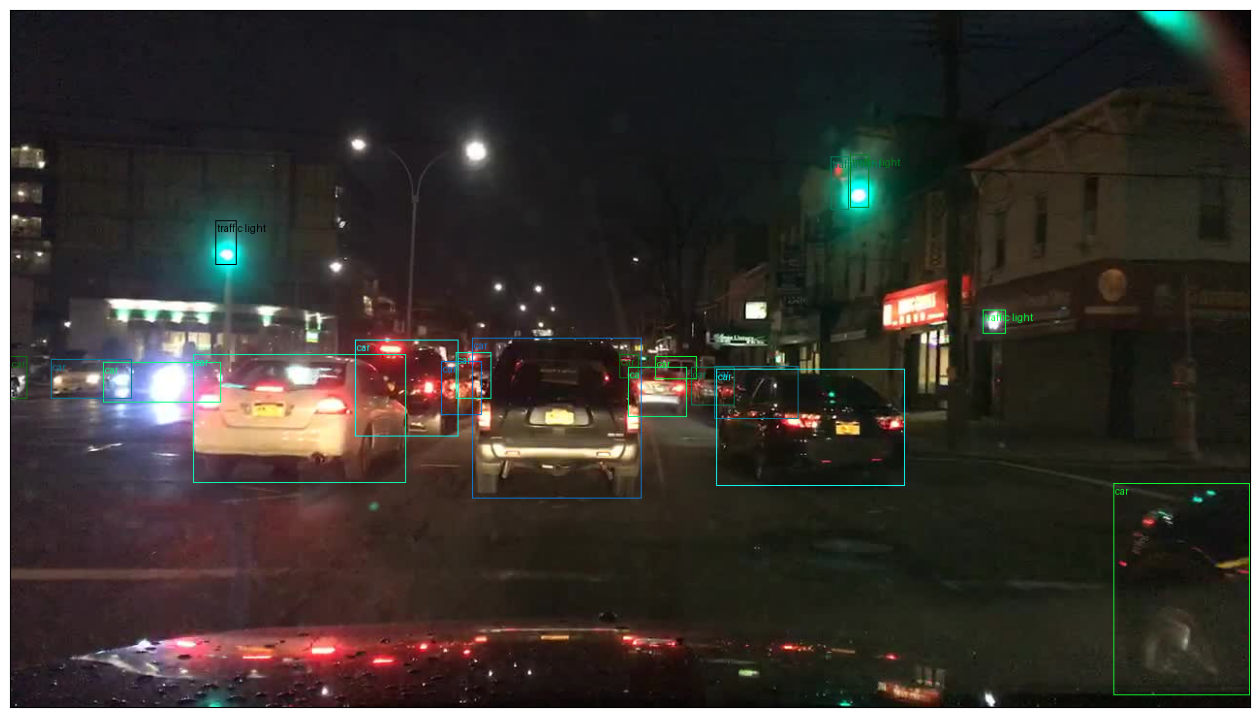

In [5]:
def show_boxes(image, boxes, names):
    drawn_boxes = draw_bounding_boxes(image, boxes, labels=names)

    plt.figure(figsize = (16,16))
    plt.imshow(np.transpose(drawn_boxes, (1, 2, 0)))  # チャンネルを一番後ろに
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
    # plt.savefig("output.png")
    plt.show()
    

dataiter = iter(dataloader_train)  # イテレータ
image, target = next(dataiter)  # バッチを取り出す
print(target)

image = image[0]
image = (image*255).to(torch.uint8)  # draw_bounding_boxes関数の入力は0-255

boxes = target["boxes"][0]

labels = target["labels"][0]
names = [index2name[label.item()] for label in labels]

show_boxes(image, boxes, names)

In [6]:
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

num_classes=len(index2name)  # 分類数: 背景も含めて分類するため1を加える
num_anchors = model.head.classification_head.num_anchors  # アンカーの数True

# 分類数を設定
model.head.classification_head.num_classes = num_classes

# 分類結果を出力する層の入れ替え
cls_logits = torch.nn.Conv2d(256, num_anchors*num_classes, kernel_size=3, stride=1, padding=1)
torch.nn.init.normal_(cls_logits.weight, std=0.01)  # RetinaNetClassificationHeadクラスより
torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))  # RetinaNetClassificationHeadクラスより
model.head.classification_head.cls_logits = cls_logits  # 層の入れ替え

# 全てのパラメータを更新不可に
for p in model.parameters():
    p.requires_grad = False

# classification_headのみパラメータを更新可能に
for p in model.head.classification_head.parameters():
    p.requires_grad = True

# model.cuda()  # GPU対応

/Users/yuhei/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yuhei/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
# 最適化アルゴリズム
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
device = torch.device("mps") if torch.has_mps else torch.device("cpu")
model.train()  # 訓練モード
model = model.to(device)  # モデルをデバイスに移動
epochs = 10
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0
# 訓練ループ
for epoch in range(epochs):
    for i, (image, target) in enumerate(dataloader_train):
        try:
            image = image.to(device)  # 画像をデバイスに移動

            boxes = target["boxes"][0].to(device)
            labels = target["labels"][0].to(device)
            target = [{"boxes": boxes, "labels": labels}]  # ターゲットは辞書を要素に持つリスト
            # print("boxes shape:", boxes.shape)  # デバッグ用に形状を出力
            loss_dic = model(image, target)
            loss = sum(loss for loss in loss_dic.values())  # 誤差の合計を計算

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:  # 100回ごとに経過を表示
                print("epoch:", epoch, "iteration:", i, "loss:", loss.item())
        except Exception as e:
            print(f"An error occurred at epoch {epoch}, iteration {i}: {e}")
            continue  # エラー発生時にこのイテレーションをスキップ
# モデルの保存
PATH = './retinanet.pth'
torch.save(model.state_dict(), PATH)

/var/folders/93/lzkt4bt950x74g63m9sjk_br0000gn/T/ipykernel_38499/711021866.py:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")


epoch: 0 iteration: 0 loss: 1.4954630136489868
epoch: 0 iteration: 10 loss: 1.1589641571044922
epoch: 0 iteration: 20 loss: 1.0313916206359863
epoch: 0 iteration: 30 loss: 0.766610860824585
epoch: 0 iteration: 40 loss: 1.025911569595337
epoch: 0 iteration: 50 loss: 0.7151975631713867
epoch: 0 iteration: 60 loss: 0.8107076287269592
epoch: 0 iteration: 70 loss: 0.4411091208457947
epoch: 0 iteration: 80 loss: 0.2670690417289734
epoch: 0 iteration: 90 loss: 0.7236093282699585
epoch: 1 iteration: 0 loss: 0.7535373568534851
epoch: 1 iteration: 10 loss: 0.9796254634857178
epoch: 1 iteration: 20 loss: 0.5524157285690308
epoch: 1 iteration: 30 loss: 0.6242055892944336
epoch: 1 iteration: 40 loss: 0.5935563445091248
epoch: 1 iteration: 50 loss: 0.8996949195861816
epoch: 1 iteration: 60 loss: 0.6843979358673096
epoch: 1 iteration: 70 loss: 0.5587739944458008
epoch: 1 iteration: 80 loss: 0.6967307329177856
epoch: 1 iteration: 90 loss: 0.763823926448822
epoch: 2 iteration: 0 loss: 0.456569910049438

In [8]:
import torch
import torchvision
device = torch.device("mps") if torch.has_mps else torch.device("cpu")
# モデルの再定義
model2 = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

num_classes=len(index2name)  # 分類数: 背景も含めて分類するため1を加える
num_anchors = model2.head.classification_head.num_anchors  # アンカーの数True

# 分類数を設定
model2.head.classification_head.num_classes = num_classes

# 分類結果を出力する層の入れ替え
cls_logits = torch.nn.Conv2d(256, num_anchors*num_classes, kernel_size=3, stride=1, padding=1)
torch.nn.init.normal_(cls_logits.weight, std=0.01)  # RetinaNetClassificationHeadクラスより
torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))  # RetinaNetClassificationHeadクラスより
model2.head.classification_head.cls_logits = cls_logits  # 層の入れ替え

# 保存したモデルの重みをロード
PATH = '../model/retinanet.pth'
model2.load_state_dict(torch.load(PATH))

# モデルを評価モードに切り替え
model2.eval()
model2 = model2.to(device)  # モデルをデバイスに移動
print(model2)


/var/folders/93/lzkt4bt950x74g63m9sjk_br0000gn/T/ipykernel_76017/3269804665.py:3: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")
/Users/yuhei/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yuhei/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


[{'boxes': tensor([[139.7336, 246.3035, 515.5284, 502.0970],
        [636.2670, 270.0439, 876.3317, 453.7140],
        [479.8381, 255.2213, 603.1849, 354.9137],
        ...,
        [137.6647, 246.8961, 515.9110, 503.5544],
        [ 21.5324, 253.2391,  39.0760, 271.5685],
        [922.4401, 190.4314, 934.6801, 205.2104]], device='mps:0',
       grad_fn=<StackBackward0>), 'scores': tensor([0.9934, 0.9707, 0.9595, 0.9487, 0.9051, 0.8885, 0.6186, 0.5805, 0.5552,
        0.5545, 0.4869, 0.4313, 0.4214, 0.3806, 0.3800, 0.3556, 0.3549, 0.3527,
        0.3487, 0.3373, 0.3223, 0.3202, 0.3167, 0.3156, 0.3038, 0.2982, 0.2951,
        0.2897, 0.2874, 0.2798, 0.2734, 0.2718, 0.2593, 0.2583, 0.2480, 0.2480,
        0.2474, 0.2469, 0.2466, 0.2460, 0.2456, 0.2447, 0.2427, 0.2370, 0.2339,
        0.2300, 0.2282, 0.2275, 0.2274, 0.2272, 0.2262, 0.2257, 0.2232, 0.2231,
        0.2196, 0.2182, 0.2181, 0.2160, 0.2149, 0.2140, 0.2139, 0.2132, 0.2132,
        0.2114, 0.2096, 0.2093, 0.2087, 0.2084, 0.2071,

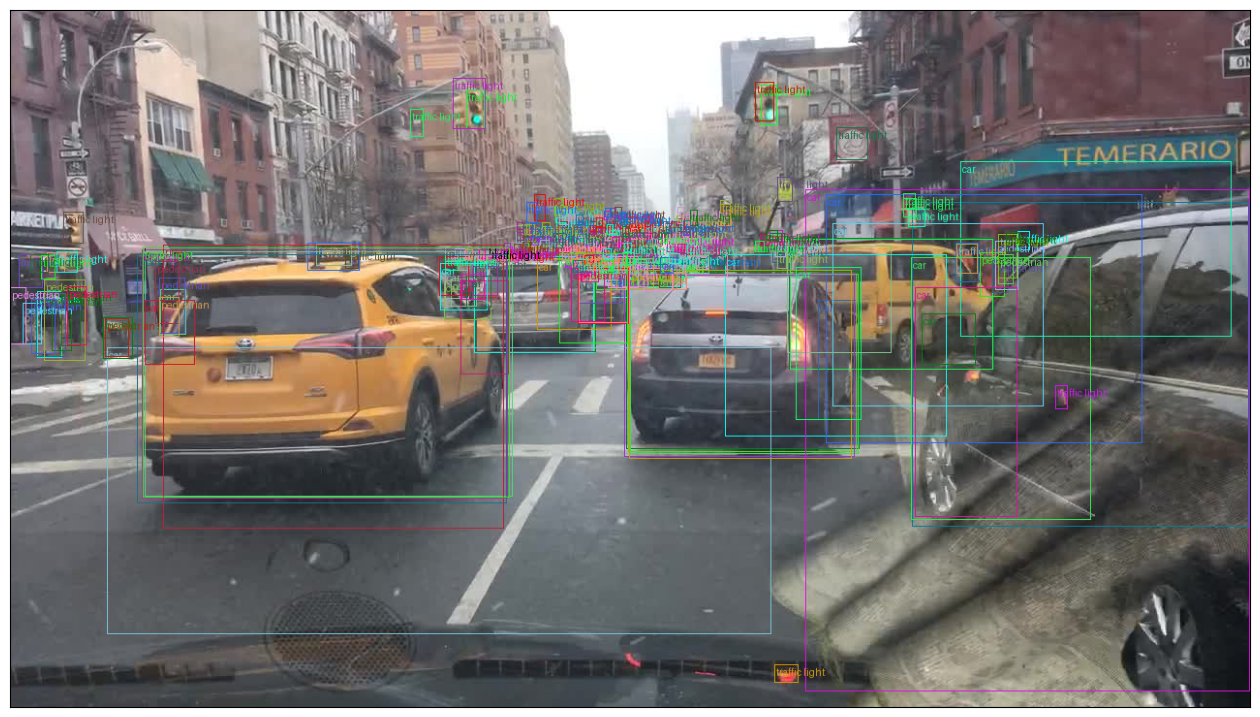

In [9]:
dataiter = iter(dataloader_val)  # イテレータ
image, target = next(dataiter)  # バッチを取り出す

image = image.to(device)  # 画像をデバイスに移動


predictions = model2(image)
print(predictions)

image = (image[0]*255).to(torch.uint8).cpu() # draw_bounding_boxes関数の入力は0-255
boxes = predictions[0]["boxes"].cpu()
labels = predictions[0]["labels"].cpu().detach().numpy()
labels = np.where(labels>=len(index2name), 0, labels)  # ラベルが範囲外の場合は0に
names = [index2name[label.item()] for label in labels]

print(names)
show_boxes(image, boxes, names)

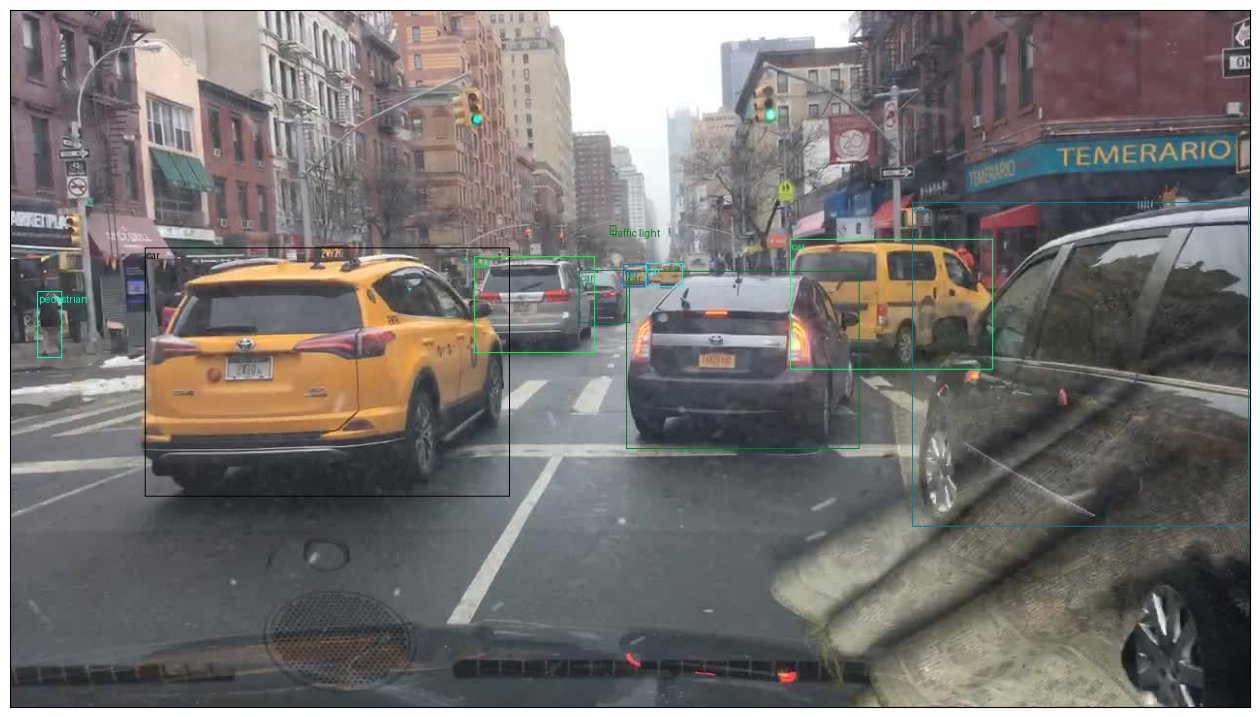

In [10]:
boxes = []
names = []
for i, box in enumerate(predictions[0]["boxes"]):
    score = predictions[0]["scores"][i].cpu().detach().numpy()
    if score > 0.5:  # スコアが0.5より大きいものを抜き出す
        boxes.append(box.cpu().tolist())
        label = predictions[0]["labels"][i].item()
        if label >= len(index2name):  # ラベルが範囲外の場合は0に
            label = 0
        name = index2name[label]
        names.append(name)
boxes = torch.tensor(boxes)

show_boxes(image, boxes, names)